Importation des packages

Description des variables de ce dataframe :
- idmutinvar = identifiant unique entre les diff bases pour retrouver chaque mutation
- idopendata = identifiant de mutation utilisé depuis l'ouverture de données DVF
- datemut = date de signature de l'acte de vente
- anneemut = annee de signature du doc
- codedep
- libnatmut = Libellé de nature de mutation tel que défini dans la donnée source DVF 6 catégories : Vente, Vente en l'état futur d'achèvement, Adjudication, Echange, Vente terrain à bâtir et Expropriation.
- vefa = booléen selon si la vente est en VEFA (vente en l'état futur d'achèvement) ou non
- valeurfonc = valeur foncière en euro déclarée lors de la vente ; prix net vendeur, inclut la TVA mais n'inclut pas les frais de notaire, d'agence ou des meubles. 
- nbcomm = nombre de communes concernée par la mutation (i.e. sur lesquelles se trouve la parcelle cadastrale concernée par la mutation)
- nbpar = comme nbcomm mais pour les parcelles.
- nbparmut = nb de parcelles ayant muté (i.e. dont la pleine propriété a été transférée lors de la mutation)
- sterr = surface de terrain ayant muté (mutation = transfert de propriété, donc surface de terrain ayant muté = surface du terrain qui a été vendu)
- nbvolmut = variable obscure, flemme 
- nblocmut = nb de locaux ayant muté
- sbati = surface de l'ensemble du bati ayant muté
- codtypbien = typologie des biens ; on pourra s'en servir pour filter les maisons et appartements et virer tous les types de batiments bizarres (cf schéma ici) https://doc-datafoncier.cerema.fr/doc/dv3f/mutation/codtypbien
- libtypbien = comme codtypbien mais pour la base DV3F et non issu de juste DVF
- geometry
- l_codeinsee = liste des codes INSEE des communes concernées par la mutation
- l_idpar =Liste des idpar qui composent l’entité (idpar = Identifiant de parcelle)
- l_idparmut = liste des identifiants de parcelles ayant muté (idpar)
- l_idlocmut = liste des identifiants de locaux ayant muté (idloc)

On peut regarder la documentation de la base DVF sur le site suivant : 
https://apidf-preprod.cerema.fr/swagger/#/DVF%2B%20(acc%C3%A8s%20libre)/dvf_opendata_geomutations_list


In [1]:
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-4ltz32sq
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-4ltz32sq
  Resolved https://github.com/inseefrlab/cartiflette to commit 2e38b5f829df6a6fa1578268112ff88853c9a4bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import geopandas as gpd
import requests
import magic
import matplotlib.pyplot as plt
from zipfile import ZipFile
import cartiflette
from io import StringIO

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


Paramétrage de l'API

In [13]:
def cleaning_json_for_gpd(data):
    for feature in data["features"]:
        properties = feature["properties"]
        for key, value in properties.items():
            if isinstance(value, list):  # Vérifie si c'est une liste
                properties[key] = ", ".join(map(str, value))  # Convertit en chaîne séparée par des virgules




In [ ]:
def recup_donnees_dvf(code_insee,annee_mut):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?anneemut={annee_mut}&code_insee={code_insee}&page_size=300"
        response = requests.get(url)
        data = response.json()
        print(data)
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                        print(data['next'])
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

In [20]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"

In [38]:
donnees_2014_issy = recup_donnees_dvf("92040","2016")

{'type': 'FeatureCollection', 'count': 1211, 'next': 'http://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?anneemut=2016&code_insee=92040&page=2&page_size=300', 'previous': None, 'features': [{'id': 13523918, 'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[2.280336, 48.820321], [2.280523, 48.820086], [2.280648, 48.819928], [2.280663, 48.81991], [2.280772, 48.819773], [2.280783, 48.819758], [2.280794, 48.819744], [2.280958, 48.819846], [2.280953, 48.819854], [2.280876, 48.819966], [2.280869, 48.819976], [2.280857, 48.819993], [2.280581, 48.820393], [2.280476, 48.820362], [2.280447, 48.820354], [2.280436, 48.820351], [2.280336, 48.820321]]]]}, 'properties': {'idmutinvar': 'ddc74e2e8b4a4158928a0db0990e43d6', 'idopendata': 'ddc74e2e8b4a4158928a0db0990e43d6', 'datemut': '2016-08-04', 'anneemut': 2016, 'coddep': '92', 'libnatmut': "Vente en l'état futur d'achèvement", 'vefa': True, 'valeurfonc': '560000.00', 'nbcomm': 1, 'l_codinsee': ['92040'], 'nbpar': 1, 'l

In [40]:
donnees_2014_issy.head()

,geometry,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,...,l_idpar,nbparmut,l_idparmut,sterr,nbvolmut,nblocmut,l_idlocmut,sbati,codtypbien,libtypbien
0,"MULTIPOLYGON (((2.28034 48.82032, 2.28052 48.8...",ddc74e2e8b4a4158928a0db0990e43d6,ddc74e2e8b4a4158928a0db0990e43d6,2016-08-04,2016,92,Vente en l'état futur d'achèvement,True,560000.00,1,...,92040000AU0090,0,None,0.00,0,1,920400021550918_0,80.00,121,UN APPARTEMENT
1,"MULTIPOLYGON (((2.24996 48.81844, 2.24993 48.8...",44dd220edaec7b62f4def40eab5c7379,44dd220edaec7b62f4def40eab5c7379,2016-11-21,2016,92,Vente,False,341500.00,1,...,920400000M0295,0,None,0.00,0,2,"920400021554186_0, 920400021554187_0",47.00,121,UN APPARTEMENT
2,"MULTIPOLYGON (((2.26688 48.82271, 2.26691 48.8...",d42edd3f79539ec65dd98511259e2df5,d42edd3f79539ec65dd98511259e2df5,2016-09-12,2016,92,Vente,False,201285.00,1,...,920400000S0257,0,None,0.00,0,1,920400021552135_0,33.00,121,UN APPARTEMENT
3,"MULTIPOLYGON (((2.24714 48.81862, 2.24715 48.8...",1715b3c64543dc96ff1c4d3747b64270,1715b3c64543dc96ff1c4d3747b64270,2016-08-24,2016,92,Vente,False,988850.00,1,...,920400000L0125,1,920400000L0125,300.00,0,1,920400021551137_0,162.00,111,UNE MAISON
4,"MULTIPOLYGON (((2.27791 48.82691, 2.27791 48.8...",dbe23a1cf4399799a8709c50ef1e1fd6,dbe23a1cf4399799a8709c50ef1e1fd6,2016-04-25,2016,92,Vente,False,30000.00,1,...,920400000X0112,0,None,0.00,0,1,920400021543284_0,0.00,131,UNE DEPENDANCE


Ok, mieux, mais il faudrait comprendre et régler ce qui s'affiche juste au dessus "Skipping field l_codinsee: unsupported OGR type: 5" (et les autres erreurs du même type)

On voit qu'il s'agit des variables qui sont de type listes (d'où le "l_"). Il faudrait changer ça. 

In [14]:
print(data['features'][0]['properties'])

{'idmutinvar': 'd89b6f2934ef835a38c1428bd5528107', 'idopendata': 'd89b6f2934ef835a38c1428bd5528107', 'datemut': '2020-06-22', 'anneemut': 2020, 'coddep': '92', 'libnatmut': 'Vente', 'vefa': False, 'valeurfonc': '23000.00', 'nbcomm': 1, 'l_codinsee': '92040', 'nbpar': 1, 'l_idpar': '92040000AM0150', 'nbparmut': 0, 'l_idparmut': None, 'sterr': '0.00', 'nbvolmut': 0, 'nblocmut': 1, 'l_idlocmut': '920400020420793_0', 'sbati': '0.00', 'codtypbien': '131', 'libtypbien': 'UNE DEPENDANCE'}


Voilà la solution : 

In [15]:
for feature in data["features"]:
    properties = feature["properties"]
    for key, value in properties.items():
        if isinstance(value, list):  # Vérifie si c'est une liste
            properties[key] = ", ".join(map(str, value))  # Convertit en chaîne séparée par des virgules

mut_gdf = gpd.GeoDataFrame.from_features(data["features"])


Vérifions : 

In [16]:
a = 0
for i in list(mut_gdf_old.keys()):
    a+=1
print(a)

18


In [17]:
mut_gdf.head()

,geometry,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,...,l_idpar,nbparmut,l_idparmut,sterr,nbvolmut,nblocmut,l_idlocmut,sbati,codtypbien,libtypbien
0,"MULTIPOLYGON (((2.26729 48.81507, 2.26702 48.8...",d89b6f2934ef835a38c1428bd5528107,d89b6f2934ef835a38c1428bd5528107,2020-06-22,2020,92,Vente,False,23000.00,1,...,92040000AM0150,0,None,0.00,0,1,920400020420793_0,0.00,131,UNE DEPENDANCE
1,"MULTIPOLYGON (((2.25007 48.81978, 2.25023 48.8...",3cee6cf31f7ab8cd4c012d2267b98b90,3cee6cf31f7ab8cd4c012d2267b98b90,2020-10-15,2020,92,Vente,False,465120.00,1,...,920400000M0282,0,None,0.00,0,1,920400020426596_0,60.00,121,UN APPARTEMENT
2,"MULTIPOLYGON (((2.25638 48.819, 2.25624 48.819...",2d7e1baff675c87cc7e73c35e49fd728,2d7e1baff675c87cc7e73c35e49fd728,2020-02-14,2020,92,Vente,False,348000.00,1,...,920400000O0084,0,None,0.00,0,2,"920400020416816_0, 920400020416817_0",62.00,121,UN APPARTEMENT
3,"MULTIPOLYGON (((2.24931 48.82294, 2.24925 48.8...",cefa8b1c1f326fc859f03e8dd1ead86c,cefa8b1c1f326fc859f03e8dd1ead86c,2020-05-26,2020,92,Vente,False,1138000.00,1,...,920400000I0080,0,None,0.00,0,3,"920400020420014_0, 920400020420015_0, 92040002...",139.00,122,DEUX APPARTEMENTS
4,"MULTIPOLYGON (((2.28839 48.81889, 2.28886 48.8...",77e6d5b83a4660d00a1edcbcc4a1cc15,77e6d5b83a4660d00a1edcbcc4a1cc15,2020-11-05,2020,92,Vente,False,101000.00,1,...,920750000N0206,0,None,0.00,0,1,920750020428646_0,18.00,14,ACTIVITE


Les colonnes ont pour la plupart des types "object" qui nous empêchent de travailler : 

In [18]:
mut_gdf.dtypes

geometry      geometry
idmutinvar      object
idopendata      object
datemut         object
anneemut         int64
coddep          object
libnatmut       object
vefa              bool
valeurfonc      object
nbcomm           int64
l_codinsee      object
nbpar            int64
l_idpar         object
nbparmut         int64
l_idparmut      object
sterr           object
nbvolmut         int64
nblocmut         int64
l_idlocmut      object
sbati           object
codtypbien      object
libtypbien      object
dtype: object

On peut changer le type d'une colonne en un autre type à spécifier. Par exemple, pour changer 'sterr' en décimaux : 

In [19]:
mut_gdf['sterr']  = mut_gdf["sterr"].astype(float)

On peut vérifier :

In [20]:
mut_gdf.dtypes

geometry      geometry
idmutinvar      object
idopendata      object
datemut         object
anneemut         int64
coddep          object
libnatmut       object
vefa              bool
valeurfonc      object
nbcomm           int64
l_codinsee      object
nbpar            int64
l_idpar         object
nbparmut         int64
l_idparmut      object
sterr          float64
nbvolmut         int64
nblocmut         int64
l_idlocmut      object
sbati           object
codtypbien      object
libtypbien      object
dtype: object

In [21]:
mut_gdf_old.shape

(272, 18)

On cherche une API pour les données par IRIS

In [ ]:

BASE_URL_API_IRIS = "https://pyris.datajazz.io/api/" 
code_iris = "786860101"
url_iris_pop = BASE_URL_API_IRIS + f"insee/population/{code_iris}"
url_iris_log = BASE_URL_API_IRIS + f"insee/logement/{code_iris}"
url_iris_act = BASE_URL_API_IRIS + f"insee/activite/{code_iris}"
# %% 
print(url_iris)

In [ ]:
response_iris_pop = requests.get(url_iris_pop)
response_iris_log = requests.get(url_iris_log)
response_iris_act = requests.get(url_iris_act)

# Vérification du succès de la requête
if response_iris.status_code == 200:
    data_iris_pop = response_iris_pop.json()
    data_iris_log = response_iris_log.json()
    data_iris_act = response_iris_act.json()
    data_iris_all = data_iris_pop | data_iris_log | data_iris_act
else:
    print(f"Erreur : {response_iris.status_code}")
# %%

In [ ]:
print(data_iris_pop.keys())
print(data_iris_log.keys())
print(data_iris_act.keys())
print(data_iris_all.keys())

Puisqu'on ne trouve pas d'API permettant de récupérer les données voulues, on essaie avec des données csv Insee

In [22]:
zip_file = ZipFile('data/BASE_TD_FILO_DISP_IRIS_2020_CSV.zip')
data_rev_disp_2020 = pd.read_csv(zip_file.open("BASE_TD_FILO_DISP_IRIS_2020.csv"), sep = ";")

In [100]:
data_rev_disp_2020.head()

,IRIS,DISP_TP6020,DISP_Q120,DISP_MED20,DISP_Q320,DISP_EQ20,DISP_D120,DISP_D220,DISP_D320,DISP_D420,...,DISP_PCHO20,DISP_PBEN20,DISP_PPEN20,DISP_PPAT20,DISP_PPSOC20,DISP_PPFAM20,DISP_PPMINI20,DISP_PPLOGT20,DISP_PIMPOT20,DISP_NOTE20
0,010040101,"20,3",14280,19450,25490,"0,58",11000,13350,15320,17530,...,"3,7","2,9","27,9","6,4","10,3","3,5","4,7","2,1","-12,3",0
1,010040102,"25,6",13280,17910,23920,"0,59",10120,12460,14200,15830,...,"4,4","2,3","24,8","6,0","12,7","3,9","5,9","2,9","-11,8",0
2,010040201,"18,4",14890,20210,26620,"0,58",11240,13860,15990,18190,...,"3,8","3,4","28,0","6,5","8,7","3,0","3,7","2,0","-13,9",0
3,010040202,"8,4",19060,24870,32100,"0,52",14380,17560,20110,22590,...,"2,8","3,8","25,0","10,8","4,7","2,0","1,9","0,8","-17,0",0
4,010330102,"22,9",14000,19810,29190,"0,77",9380,12670,15070,17560,...,"4,9","1,7","24,1","6,5","6,0","1,5","3,0","1,5","-13,0",0


In [31]:
zip_file = ZipFile('data/base-ic-logement-2018_csv.zip')
data_log_2018 = pd.read_csv(zip_file.open("base-ic-logement-2018.CSV"), sep = ";")

/tmp/ipykernel_130528/4091248581.py:2: DtypeWarning: Columns (0,1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  data_log_2018 = pd.read_csv(zip_file.open("base-ic-logement-2018.CSV"), sep = ";")


In [32]:
data_log_2018.head()

,IRIS,COM,TYP_IRIS,MODIF_IRIS,LAB_IRIS,P18_LOG,P18_RP,P18_RSECOCC,P18_LOGVAC,P18_MAISON,...,P18_RP_GARL,P18_RP_VOIT1P,P18_RP_VOIT1,P18_RP_VOIT2P,P18_RP_HABFOR,P18_RP_CASE,P18_RP_MIBOIS,P18_RP_MIDUR,C18_RP_HSTU1P,C18_RP_HSTU1P_SUROCC
0,10010000,1001,Z,0,5,353.730435,311.000000,16.278261,26.452174,345.478380,...,265.393980,296.516547,102.803725,193.712822,NaN,NaN,NaN,NaN,315.280085,0.000000
1,10020000,1002,Z,0,5,174.392742,105.156379,52.945455,16.290909,174.392742,...,79.127572,102.032922,30.193416,71.839506,NaN,NaN,NaN,NaN,109.320988,5.205761
2,10040101,1004,H,0,1,912.510530,810.120307,22.046419,80.343805,305.588622,...,532.830267,672.478518,433.883533,238.594985,NaN,NaN,NaN,NaN,704.561443,21.179023
3,10040102,1004,H,0,1,2035.523255,1789.066937,17.588920,228.867398,464.526974,...,1194.036317,1469.199628,1059.946678,409.252950,NaN,NaN,NaN,NaN,1685.793830,88.192059
4,10040201,1004,H,0,1,2198.025443,1957.404744,21.657501,218.963198,797.696361,...,1307.809318,1628.724670,1109.955313,518.769357,NaN,NaN,NaN,NaN,1909.628628,58.036074


In [28]:
magic.from_file('data/base-ic-logement-2018_csv.zip')

'Zip archive data, at least v2.0 to extract, compression method=deflate'

On va chercher tous les IRIS de Paris 15ème

In [17]:
base_url_iris = "https://pyris.datajazz.io/api/city/code"

code_insee = "75115" #attention, un code Insee n'est que rarement le code postal
url_iris_code = base_url_iris + f"/{code_insee}"
# %% 
print(url_iris_code)

response = requests.get(url_iris_code)#, params=params)
# Vérification du succès de la requête
if response.status_code == 200:
    data_iris = response.json()  # On récupère les données au format JSON
else:
    print(f"Erreur : {response.status_code}")
# %%
print(type(data_iris))
print(data_iris) #on a la lis

https://pyris.datajazz.io/api/city/code/75115
<class 'list'>
['751155912', '751155711', '751155721', '751156021', '751155718', '751155717', '751155716', '751155712', '751155710', '751155808', '751156023', '751155914', '751155908', '751156012', '751155703', '751155911', '751155707', '751155907', '751155731', '751155999', '751156007', '751156019', '751156017', '751155809', '751156013', '751155708', '751155702', '751156005', '751156010', '751155705', '751155812', '751155803', '751155813', '751155810', '751155801', '751155723', '751156020', '751155704', '751155804', '751155903', '751155805', '751155720', '751155919', '751156006', '751155904', '751156008', '751155729', '751155909', '751156018', '751155910', '751156015', '751156004', '751155730', '751155915', '751155715', '751156002', '751155819', '751156001', '751155815', '751155920', '751155714', '751155807', '751155701', '751156016', '751155814', '751155802', '751155816', '751155706', '751155916', '751156009', '751155902', '751155713', '7

On a ainsi obtenu la liste des IRIS présents dans Paris 15ème
On va maintenant obtenir les coordonnées géographiques de tous ces IRIS

Dans l'autre sens : on part des adresses et on leur attribue leur IRIS

Ci-dessous : voici comment récupérer l'IRIS d'une coordonnée géographique
Problème : si on doit requêter les coordonnées de toutes les adresses qui nous intéresse, ça pourrait être un peu fastidieux


In [131]:
base_url_api = "https://pyris.datajazz.io/api/"
lat, lon = 48.71715, 1.89657

url_adresse_to_iris = base_url_api + f"coords?geojson=true&lat={lat}&lon={lon}"
# %% 
print(url_adresse_to_iris)

response_adresse_to_iris = requests.get(url_adresse_to_iris)#, params=params)
# Vérification du succès de la requête
if response_adresse_to_iris.status_code == 200:
    data_adresse_to_iris = response_adresse_to_iris.json()  # On récupère les données au format JSON
    print("ok")
else:
    print(f"Erreur : {response_adresse_to_iris.status_code}")
# %%
print(type(data_adresse_to_iris))
print(data_adresse_to_iris) 

https://pyris.datajazz.io/api/coords?geojson=true&lat=48.71715&lon=1.89657
ok
<class 'dict'>
{'type': 'Feature', 'properties': {'citycode': '78220', 'name': 'Romanie', 'type': 'H', 'complete_code': '782200101', 'city': 'Les Essarts-le-Roi', 'iris': '0101'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[1.90474453630957, 48.7321779179585], [1.90478480712923, 48.7320082808386], [1.90489087669467, 48.731683632815], [1.90547752335322, 48.7304225083681], [1.9046318996036, 48.7272718676691], [1.90385347442541, 48.7261718156424], [1.90356993378123, 48.725494577739], [1.90315828618928, 48.724508528237], [1.90275443203992, 48.723540538254], [1.902586834332, 48.7229111369132], [1.90246401921244, 48.7223505099009], [1.90255053433326, 48.7214679825293], [1.90397696723255, 48.7212580126309], [1.90427152155834, 48.7212148423911], [1.90463698119621, 48.72116152812], [1.90468870702931, 48.7211584048468], [1.90735739523449, 48.721027254024], [1.91025304884677, 48.7209637810208], [1.9122000897

Puisque c'est un peu laborieux, dans l'autre sens : on a récupéré un fichier des coordonnées spatiales des IRIS en ile de France

In [132]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [133]:
mut_gdf_old["geometry"].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ok, on est bien en format 4326 (=WGS 84) pour les deux fichiers, on va pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite relier ça aux fichiers Insee)

In [134]:
data_mut_avec_iris = gpd.sjoin(mut_gdf_old, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_avec_iris.head())

                         idmutinvar                        idopendata  \
0  72f7d15beebbeaaf8a5002f32fb5fbe0  72f7d15beebbeaaf8a5002f32fb5fbe0   
1  57693d6d16e8a1d057c73ba86ca6f6c9  57693d6d16e8a1d057c73ba86ca6f6c9   
2  bb0aac068a3309cc4471f2c355e5ea78  bb0aac068a3309cc4471f2c355e5ea78   
3  a2ef34c10ee5f970b715b8ec51b099e7  a2ef34c10ee5f970b715b8ec51b099e7   
4  97fb1518ba1ddb078df9dbfae40a0a8c  97fb1518ba1ddb078df9dbfae40a0a8c   

     datemut  anneemut coddep libnatmut   vefa valeurfonc  nbcomm  nbpar  ...  \
0 2024-02-07      2024     92     Vente  False  412000.00       1      1  ...   
1 2024-03-13      2024     92     Vente  False   18000.00       1      1  ...   
2 2024-01-29      2024     92     Vente  False  389000.00       1      1  ...   
3 2024-01-24      2024     92     Vente  False  435000.00       1      1  ...   
4 2024-03-29      2024     92     Vente  False  162000.00       1      1  ...   

                                            geometry index_right  \
0  MUL

Les iris apparaissent bien dans le fichier des mutations
Dernière étape : relier ça aux données Insee "test" (celle des revenus disp de 2020)

In [135]:
data_mut_et_insee = data_mut_avec_iris.join(data_rev_disp_2020, how="left")

In [136]:
data_mut_et_insee.head(5)

,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,nbpar,...,DISP_PCHO20,DISP_PBEN20,DISP_PPEN20,DISP_PPAT20,DISP_PPSOC20,DISP_PPFAM20,DISP_PPMINI20,DISP_PPLOGT20,DISP_PIMPOT20,DISP_NOTE20
0,72f7d15beebbeaaf8a5002f32fb5fbe0,72f7d15beebbeaaf8a5002f32fb5fbe0,2024-02-07,2024,92,Vente,False,412000.00,1,1,...,"3,7","2,9","27,9","6,4","10,3","3,5","4,7","2,1","-12,3",0
1,57693d6d16e8a1d057c73ba86ca6f6c9,57693d6d16e8a1d057c73ba86ca6f6c9,2024-03-13,2024,92,Vente,False,18000.00,1,1,...,"4,4","2,3","24,8","6,0","12,7","3,9","5,9","2,9","-11,8",0
2,bb0aac068a3309cc4471f2c355e5ea78,bb0aac068a3309cc4471f2c355e5ea78,2024-01-29,2024,92,Vente,False,389000.00,1,1,...,"3,8","3,4","28,0","6,5","8,7","3,0","3,7","2,0","-13,9",0
3,a2ef34c10ee5f970b715b8ec51b099e7,a2ef34c10ee5f970b715b8ec51b099e7,2024-01-24,2024,92,Vente,False,435000.00,1,1,...,"2,8","3,8","25,0","10,8","4,7","2,0","1,9","0,8","-17,0",0
4,97fb1518ba1ddb078df9dbfae40a0a8c,97fb1518ba1ddb078df9dbfae40a0a8c,2024-03-29,2024,92,Vente,False,162000.00,1,1,...,"4,9","1,7","24,1","6,5","6,0","1,5","3,0","1,5","-13,0",0


On commence à faire vite-fait un peu de visualisation spatiale

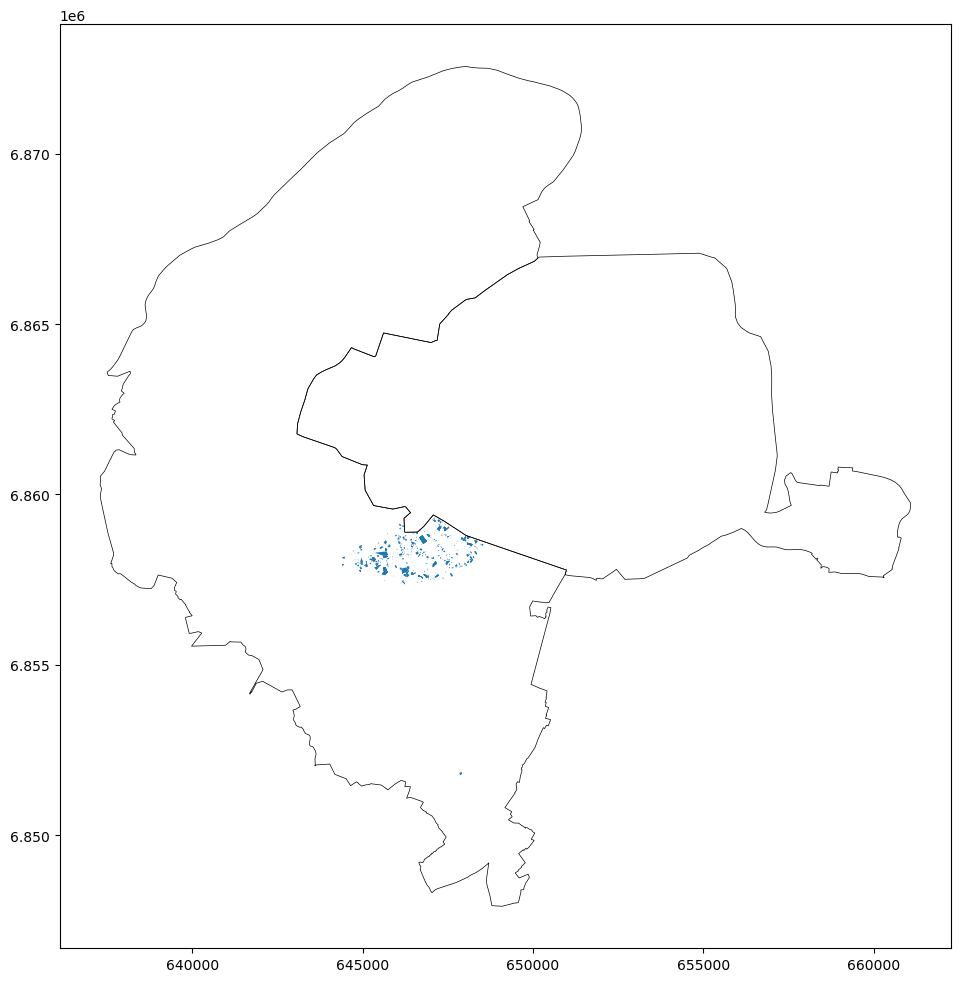

In [137]:
idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_paris_92 = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()



On a sélectionné ici au début du code les villes de Vanves et Issy les Moulineaux, d'où le fait que les tâches de couleur s'affichent sur une zone localisée (uniquement les villes concernées)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie, mais au moins on sait le faire fonctionner grosso modo